In [1]:
import clip
import torch
import numpy as np
import pandas as pd
import math
from PIL import Image
import os
from pathlib import Path

/Users/harrywang/sandbox/clip-tasks/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set the path to the photos
photos_path = Path("./1k-compressed")

# List all JPGs in the folder
photos_files = list(photos_path.glob("*.jpg"))
print(f"Total Photos: {len(photos_files)}")

Total Photos: 1000


In [3]:
# Load the open CLIP model
# select device: mps for Apple M1, cuda for GPU

#device = "cuda" if torch.cuda.is_available() else "cpu"
device = "mps" if torch.backends.mps.is_available() else "cpu"
print('device is:', device)
model, preprocess = clip.load("ViT-B/32", device=device)

# Function that computes the feature vectors for a batch of images
def compute_clip_features(photos_batch):
    # Load all the photos from the files
    photos = [Image.open(photo_file) for photo_file in photos_batch]
    
    # Preprocess all photos by stacking the result for each photo
    photos_preprocessed = torch.stack([preprocess(photo) for photo in photos]).to(device)

    with torch.no_grad():
        # Encode the photos batch to compute the feature vectors and normalize them
        photos_features = model.encode_image(photos_preprocessed)
        photos_features /= photos_features.norm(dim=-1, keepdim=True)

    # Transfer the feature vectors back to the CPU and convert to numpy
    return photos_features.cpu().numpy()

device is: mps


In [4]:
# Define the batch size so that it fits on your GPU
batch_size = 200

# Path where the feature vectors will be stored
features_path = Path("./1k-features") 

# Compute how many batches are needed
batches = math.ceil(len(photos_files) / batch_size)

# Process each batch
for i in range(batches):
    print(f"Processing batch {i+1}/{batches}")

    batch_ids_path = features_path / f"{i:02d}.csv"
    batch_features_path = features_path / f"{i:02d}.npy"
    
    # Only do the processing if the batch wasn't processed yet
    if not batch_features_path.exists():
        try:
            # Select the photos for the current batch
            batch_files = photos_files[i*batch_size : (i+1)*batch_size]

            # Compute the features and save to a numpy file
            batch_features = compute_clip_features(batch_files)
            np.save(batch_features_path, batch_features)

            # Save the photo IDs to a CSV file
            photo_ids = [photo_file.name.split(".")[0] for photo_file in batch_files]
            photo_ids_data = pd.DataFrame(photo_ids, columns=['photo_id'])
            photo_ids_data.to_csv(batch_ids_path, index=False)
        except:
            # Catch problems with the processing to make the process more robust
            print(f'Problem with batch {i}')
    else:
        print('this batch has been processed - skipped')

Processing batch 1/5
Processing batch 2/5
Processing batch 3/5
Processing batch 4/5
Processing batch 5/5


In [5]:
# Merge the features and the photo IDs. The resulting files are `features.npy` and `photo_ids.csv`.

if not os.path.exists('./1k-features/features.npy'):
    # Load all numpy files
    features_list = [np.load(features_file) for features_file in sorted(features_path.glob("*.npy"))]

    # Concatenate the features and store in a merged file
    features = np.concatenate(features_list)
    np.save(features_path / "features.npy", features)
else:
    print('feature file already exists.')

if not os.path.exists('./1k-features/photo_ids.csv'):
    # Load all the photo IDs
    photo_ids = pd.concat([pd.read_csv(ids_file) for ids_file in sorted(features_path.glob("*.csv"))])
    photo_ids.to_csv(features_path / "photo_ids.csv", index=False)
else:
    print('photo id file already exists.')

feature file already exists.
photo id file already exists.


In [6]:
# Read the photos table
photos = pd.read_csv("photos-1k.csv")

# Load the features and the corresponding IDs
photo_features = np.load(features_path / "features.npy")
photo_ids = pd.read_csv(features_path / "photo_ids.csv")

photo_ids = list(photo_ids['photo_id'])

In [7]:
# Specify your search query and encode it to a feature vector using CLIP.
#search_query = "dog"
search_query = "dog in the snow"

with torch.no_grad():
    # Encode and normalize the description using CLIP
    text_encoded = model.encode_text(clip.tokenize(search_query).to(device))
    text_encoded /= text_encoded.norm(dim=-1, keepdim=True)

In [8]:
# Compare the text features to the image features and find the best match.

# Retrieve the description vector and the photo vectors
text_features = text_encoded.cpu().numpy()

# Compute the similarity between the description and each photo using the Cosine similarity
# @ is matrix product of two tensors torch.matmul() : https://pytorch.org/docs/stable/generated/torch.matmul.html
similarities = list((text_features @ photo_features.T).squeeze(0))

# Sort the photos by their similarity score
# each item in the list is tuple (similarity_score, photo_index)
best_photos = sorted(zip(similarities, range(photo_features.shape[0])), key=lambda x: x[0], reverse=True)

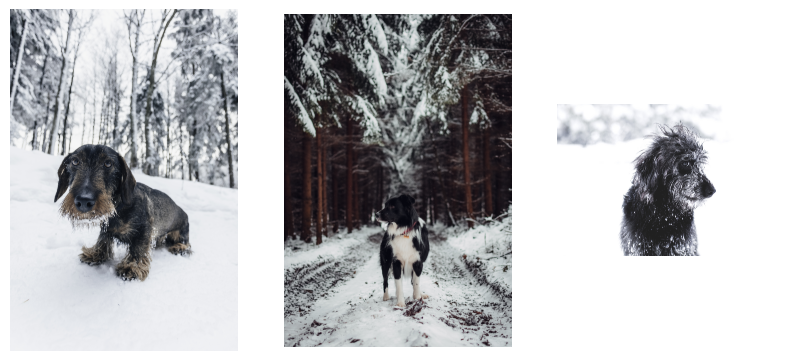

In [9]:
# display the result horizontally 
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

top_k = 3
ids = [x[1] for x in best_photos[:top_k]]
top_photos = [f'./1k/'+ photo_ids[idx] + '.jpg' for idx in ids]

fig = figure(figsize=(10, 30))

for i in range(top_k):
    fig.add_subplot(1, top_k, i+1)
    image = imread(top_photos[i])
    imshow(image)
    axis('off')